# Introduction to RISE, Grad-CAM, and RISE-CAM
RISE-CAM is an Explainable AI algorithm based on the mechanisms of two classic Explainable AI algorithms--RISE and Grad-CAM.

In this notebook, two of the classic algorithms will be introduced with corresponding codes to fully explain the algorithm of RISE-CAM.

For the evaluation between alrgorithms, please read Evaluation_RISECAM.ipynb.

## Preparation

### Import nessasary libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data

from torchvision import models
from torchvision import transforms
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image

cudnn.benchmark = True
torch.cuda.get_device_name()

c:\Users\choulwu2\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NVIDIA GeForce RTX 2080 Ti'

### Define or import functions

In [2]:
from torchcam.methods import SmoothGradCAMpp

from algorithms import tensor_imshow, get_class_name, RISE, RISECAM

# Set the size of the input image.
input_size = (224, 224)

# Function that opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0)
])

# Read the input image as a tensor.
input_tensor = read_tensor('examples/dogs.png')

### Load black-box model

In [3]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

c:\Users\choulwu2\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\choulwu2\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Randomized Image Sampling for Explanations (RISE)
RISE contains four steps:
1. Generate masks.
2. Apply the masks on the image.
3. Feed the masked images into the model.
4. Multiply the confidence of a certain class with the masks and sum them up to get the saliency maps.

RISE will return all the saliency maps for every classes at the same time. 

Stpes 2, 3, and 4 are done in algorithms.py so only step 1 is demonstrated here.

### Create the explainer instance

In [4]:
rise_explainer = RISE(model, input_size)

### Generate or load masks (step 1)
Generate masks for RISE. If masks already exist, load the masks. The file masks_100.npy is provided only for testing purpose. Please generate a mask file with 6000 masks for a more presice explanation.

Here $N$ is the number of the masks, $s$ is the number of the grid, and $p1$ is the probability of an area in the grid is selected.

In [5]:
# Generate 6000 masks for a presice explanation.

rise_explainer.generate_masks(N=6000, s=8, p1=0.1, savepath='masks_6000.npy')
# rise_explainer.load_masks('masks_6000.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


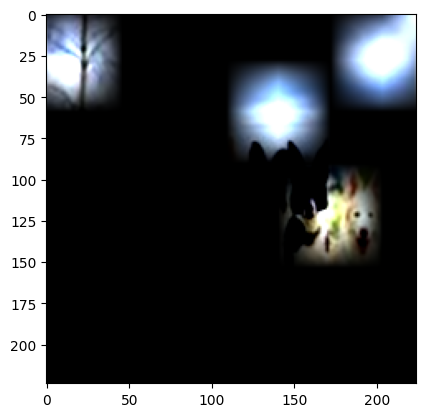

In [6]:
# Display one masks on the image.
masked_imgs = torch.mul(torch.from_numpy(np.load('masks_6000.npy')).float(), input_tensor)
plt.imshow(np.asarray(masked_imgs[0].squeeze().permute(1,2,0)), cmap='jet')

### Explain the input image (steps 2, 3, 4)
Producing saliency maps for top $k$ predicted classes.

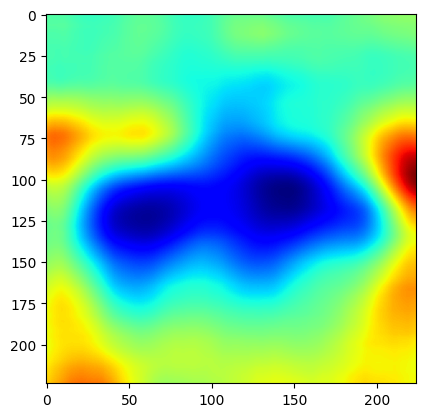

In [7]:
# Get the saliency maps and display one of the map.
rise_sals = rise_explainer(input_tensor.cuda()).cpu().numpy()
plt.imshow(rise_sals[0], cmap='jet')

### Display the saliency maps of the top 5 predicted classes

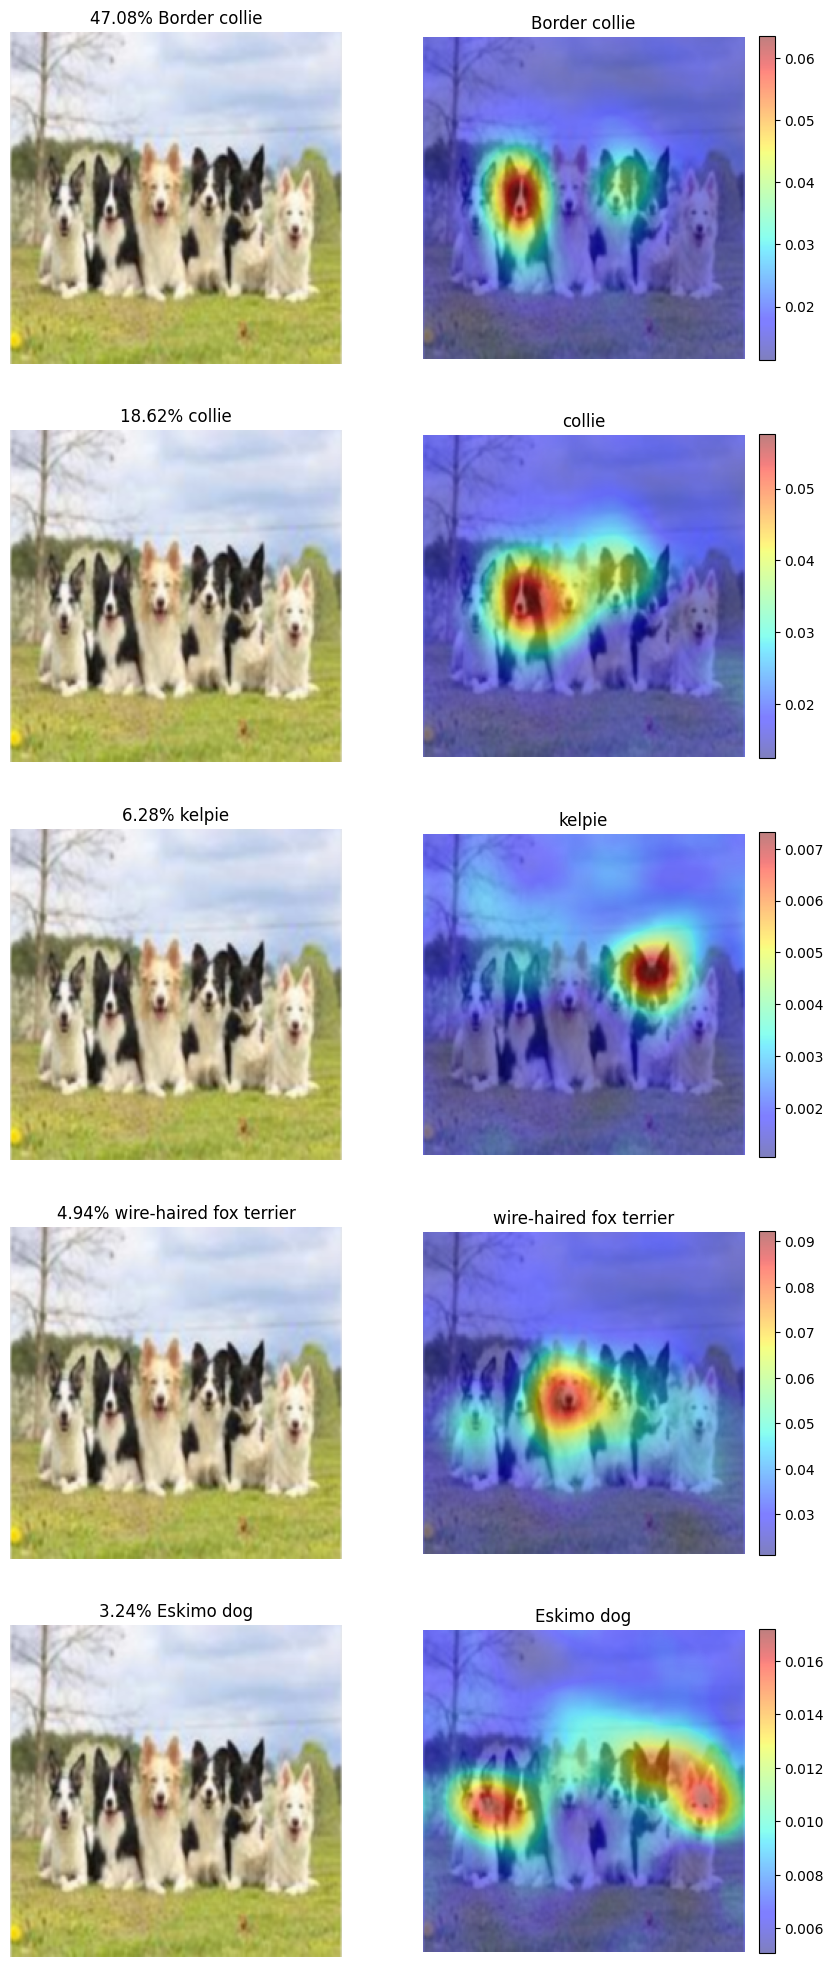

In [8]:
top_k = 5

p, c = torch.topk(model(input_tensor.cuda()), k=top_k)
p, c = p[0], c[0]

plt.figure(figsize=(10, 5*top_k))
for k in range(top_k):
    plt.subplot(top_k, 2, 2*k+1)
    plt.axis('off')
    plt.title('{:.2f}% {}'.format(100*p[k], get_class_name(c[k])))
    tensor_imshow(input_tensor[0])

    plt.subplot(top_k, 2, 2*k+2)
    plt.axis('off')
    plt.title(get_class_name(c[k]))
    tensor_imshow(input_tensor[0])
    rise_sal = rise_sals[c[k]]
    plt.imshow(rise_sal, cmap='jet', alpha=0.5)
    plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

## Gradient-weighted Class Activation Mapping (Grad-CAM)
Grad-CAM contains four steps:
1. Hook the model with a Grad-CAM extractor and designated a layer (or it will select the feature layer automatically).
2. Feed the image into the model and get the output predicted classes.
3. Feed output and a desired class into the Grad-CAM extractor to generate a feature saliency map with the size of the feature layer.
4. Resize the saliency map to the size of the image.

Instead of Grad-CAM, Smooth Grad-CAM++ is used to represent the whole Grad-CAM family because it is a slighted improved version of Grad-CAM withbetter time complexity.

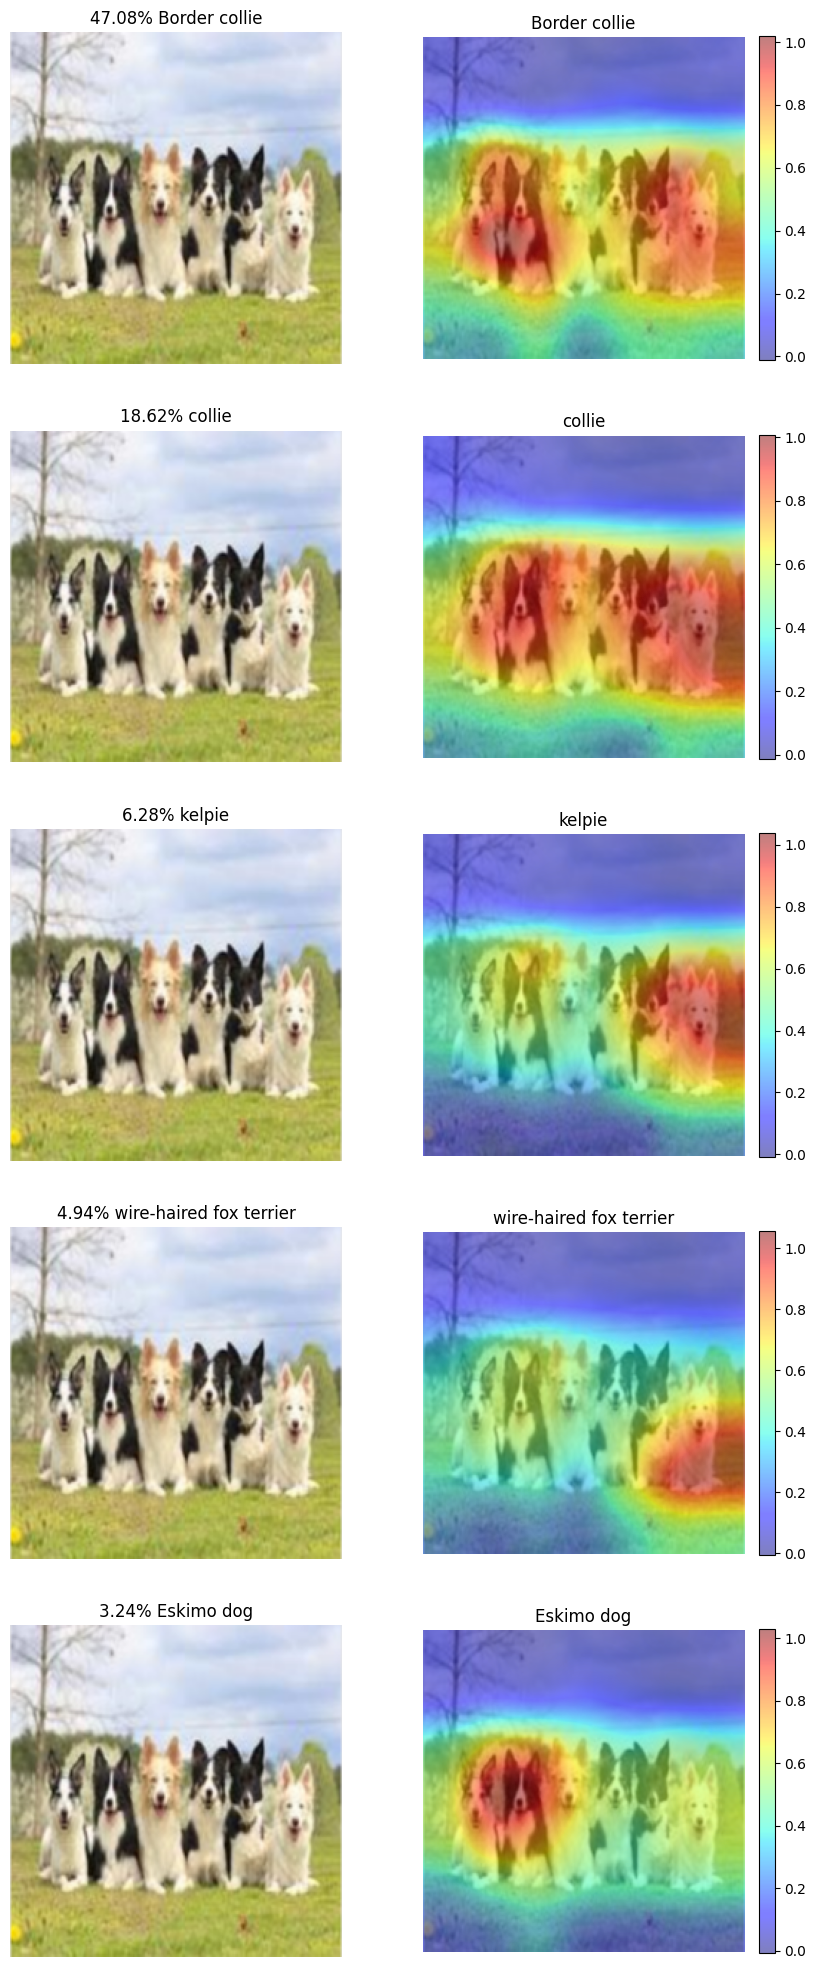

In [9]:
input_tensor.requires_grad = True
top_k = 5
img = to_pil_image(read_image('examples/dogs.png')).resize((224, 224), resample=Image.BICUBIC)

# Hook the model with a Grad-CAM extractor and designated a layer (or it will select the feature layer automatically).
with SmoothGradCAMpp(model) as cam_extractor:

    # Feed the image into the model and get the output predicted classes.
    out = model(input_tensor.cuda())
    probabilities, classes = torch.topk(out, k=top_k)
    probabilities, classes = probabilities[0], classes[0]

    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*probabilities[k], get_class_name(classes[k])))
        plt.imshow(img)

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(get_class_name(classes[k]))
        plt.imshow(img)

        # Feed output and a desired class into the Grad-CAM extractor to generate a feature saliency map with the size of the feature layer.
        feature_sal = cam_extractor(classes[k].item(), out)

        # Resize the saliency map to the size of the image.
        gradcam_sal = to_pil_image(feature_sal[0].squeeze(0), mode='F').resize(img.size, resample=Image.BICUBIC)
        
        plt.imshow(np.asarray(gradcam_sal), cmap='jet', alpha=0.5)
        # Display it
        plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

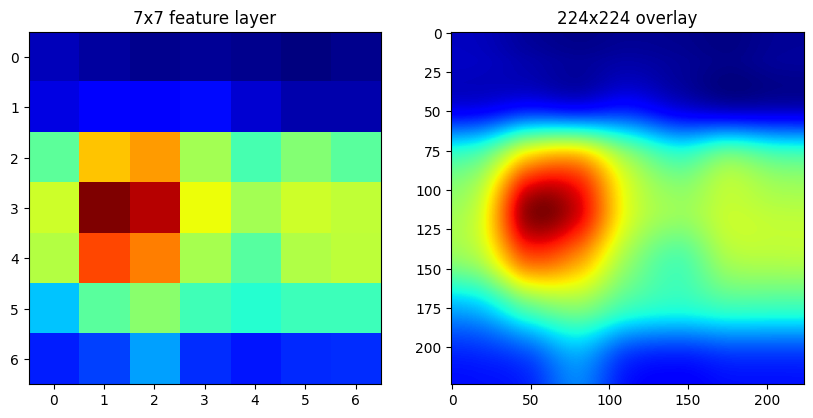

In [10]:
# How a feature saliency map is resized to the size of the image.
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('7x7 feature layer')
plt.imshow(np.asarray(feature_sal[0][0].cpu()), cmap='jet')

plt.subplot(1, 2, 2)
plt.title('224x224 overlay')
plt.imshow(np.asarray(gradcam_sal), cmap='jet')

## RISE-CAM
RISE-CAM contains four steps:
1. Generate masks.
2. Apply the masks on the image.
3. Hook the model with a Grad-CAM extractor and designated a layer (or it will select the feature layer automatically).
4. Feed each masked image into the model and get the output predicted classes.
5. Feed outputs of all the masked images and a desired class into the Grad-CAM extractor to generate feature saliency maps with the size of the feature layer. The outputs of this step are N feature saliency maps, each explaining one masked image.
6. Multiply the value of the features with the masks and sum them up to get the saliency maps for each feature on the feature layer. In this case, there are $7*7=49$ features on the feature layer, so the output will be 49 saliency maps.
7. Perform Grad-CAM on the original image and get the feature saliency map and rank the top $k$ features.
8. Take the mean of the saliency maps of the top $k$ features from Grad-CAM.

Steps 2, 3, 4, 5, and 6 are done in algorithms.py so only step 1, 7, and 8 will be demonstrated.

The Grad-CAM is actually Smooth Grad-CAM++ as well. For a better explaination, Smooth Grad-CAM will be executed 100 times, so that the top $k$ features can be selected in the most stable way.

Due to the time complexity of RISE-CAM, only the first predicted class will be explained. The comparison here is between different $k$ rather than different classes as the previous two demonstrations.

### Create the explainer instance

In [11]:
risecam_explainer = RISECAM(model, input_size)

### Generate or load masks (step 1)
Generate masks for RISECAM. If masks already exist, load the masks.

Here $N$ is the number of the masks, $s$ is the number of the grid, and $p1$ is the probability of an area in the grid is selected.

In [12]:
# If masks already exist (generated in the previous session), load the masks.

# risecam_explainer.generate_masks(N=6000, s=8, p1=0.1, savepath='masks_6000.npy')
risecam_explainer.load_masks('masks_6000.npy')

### Explain the input image (steps 2, 3, 4, 5, 6)
Producing saliency maps for each feature on the feature layer.

In [13]:
# Explain the image.
input_tensor.requires_grad = True
risecam_sals = risecam_explainer(input_tensor.cuda()).cpu().numpy()
input_tensor.requires_grad = False

100%|██████████| 6000/6000 [09:53<00:00, 10.11it/s]


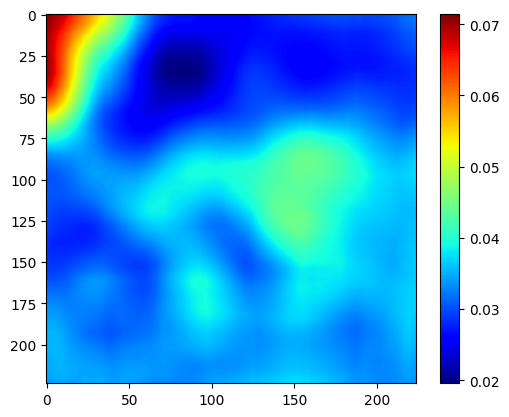

In [14]:
# Display the saliency map of the top-left feature. The saliency map is highlighting that corner.
plt.imshow(risecam_sals[0][0], cmap='jet')
plt.colorbar()

### Perform Grad-CAM on the original image and get the feature saliency map and rank the top $k$ features (steps 7)

In [15]:
# Perform Smooth Grad-CAM++ on the original image for 100 times and get the mean feature saliency map.
input_tensor.requires_grad = True
with SmoothGradCAMpp(model) as cam_extractor:
    out = model(input_tensor.cuda())
    p, c = torch.topk(out, k=1)
    p, c = p[0], c[0]
    gradcam_sal_100 = np.mean([cam_extractor(c[0].item(), out)[0][0].cpu().numpy() for _ in range(100)], axis=0)
input_tensor.requires_grad = False

### Take the mean of the saliency maps of the top $k$ features from Grad-CAM (step 8)
The demonstration below show the reslut of choosing different $k$s. The displayed images are the mean of the top $k$ feature saliency maps.

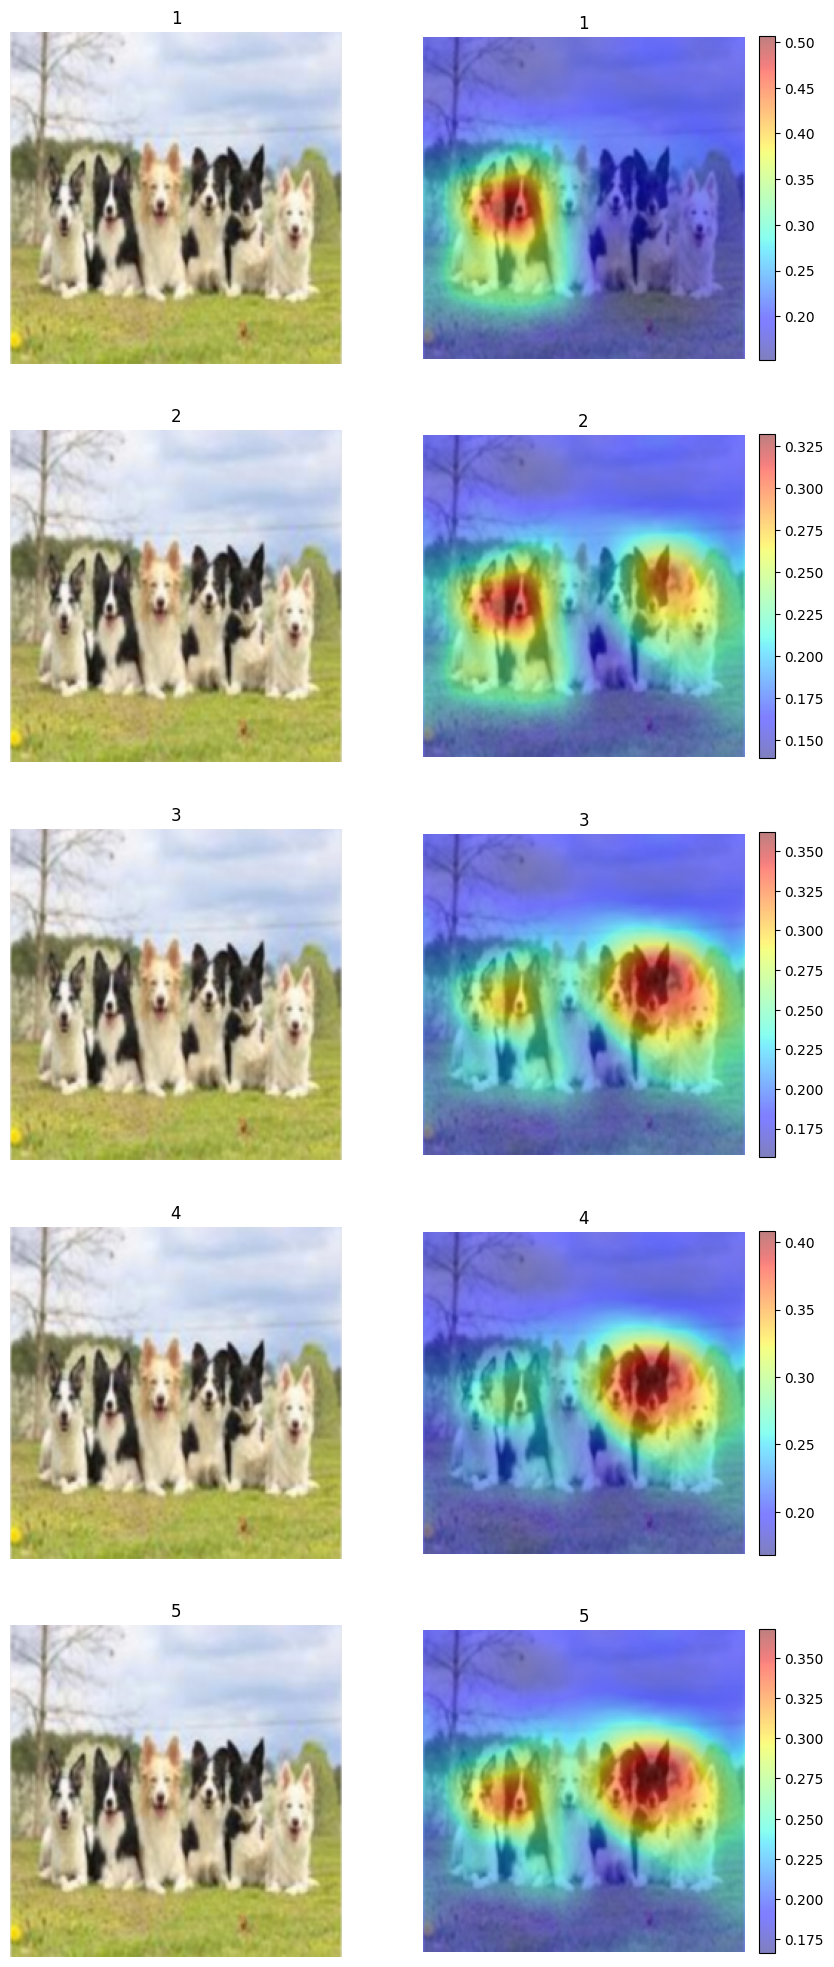

In [16]:
# Flatten the saliency map to select top k.
range_top_k = 5
feature_height, feature_width, height, width = risecam_sals.shape
gradcam_sal_topk = gradcam_sal_100.reshape(feature_height*feature_width)
risecam_sals_flatten = risecam_sals.reshape(feature_height*feature_width, height, width)

# Show the mean of the top 5 feature saliency maps.
plt.figure(figsize=(10, 5*range_top_k))
for k in range(range_top_k):
    top_k = k+1

    plt.subplot(range_top_k, 2, 2*k+1)
    plt.axis('off')
    plt.title(top_k)
    tensor_imshow(input_tensor[0])

    plt.subplot(range_top_k, 2, 2*k+2)
    plt.axis('off')
    plt.title(top_k)
    tensor_imshow(input_tensor[0])
    
    # Select the top k feature saliency maps based on the reslut of Grad-CAM.
    indices = np.argpartition(gradcam_sal_topk, -top_k)[-top_k:]
    risecam_sal = np.mean(risecam_sals_flatten[indices], axis=0)
    
    plt.imshow(risecam_sal, cmap='jet', alpha=0.5)
    # Display it
    plt.colorbar(fraction=0.046, pad=0.04)

plt.show()